In [1]:
import copy
import numpy as np
import os
import verdict

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms
%matplotlib inline

In [3]:
import analysis_config

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as a_w_set
import linefinder.analyze_data.plot_worldlines as p_worldlines

In [5]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as linefinder_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.utils.astro as astro_utils
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

# Load Data

In [7]:
do_calculation = False

In [8]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 172, galdef 


In [9]:
tag_tail = '_CGM_snum{}'.format( snum )

In [10]:
ahf_index = 600

In [11]:
ind = ahf_index - snum

In [12]:
# Load the a helper for loading files easily
file_manager = file_management.FileManager( project='CGM_fate' )

In [13]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail, 
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)

In [14]:
w_set = a_w_set.WorldlineSet( defaults, variations )

## Get Processed Data

In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )
classification_list.append( 'is_in_CGM' )
classification_list.append( 'is_in_CGM_not_sat' )

In [16]:
if do_calculation:
    
    data_keys = [ 'T', 'Z_asplund', 'M' ]
    
    # Prep the Data Structure
    data = {}
    for data_key in data_keys:
        data[data_key] = {}
        for classification in classification_list:
            data[data_key][classification] = {}

    # Get the data
    for sim_name in w_set.keys():

        print( sim_name )

        for classification in classification_list:

            w = w_set[sim_name].data_object

            w.mask_data( 'PType', data_value=0 )
            w.mask_data( 'is_in_CGM_not_sat', data_value=True )

            for data_key in data_keys:
                data[data_key][classification][sim_name] = w.get_selected_data(
                    data_key,
                    sl = (slice(None),ind),
                    classification = classification
                )

        w.clear_data()    

#### Halo Masses

In [17]:
if do_calculation:
    w_set.data_object.retrieve_halo_data()
    halo_masses = w_set.m_vir.inner_item( snum )
    virial_temps = w_set.t_vir.inner_item( snum )

#### Save and load results

In [18]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_fates_temps_and_mets_snum{}.hdf5'.format( snum ),
)

In [19]:
if do_calculation:
    
    data = verdict.Dict( data )

    # Format results to save
    results_to_save = copy.deepcopy( verdict.Dict( data ) )
    results_to_save['m_vir'] = halo_masses
    results_to_save['t_vir'] = virial_temps

    results_to_save.to_hdf5(
        savefile, 
        condensed = False, 
        attributes = { 'redshift': w.redshift.values[ind] },
    )
    
    redshift = w.redshift.values[ind]

In [20]:
if not do_calculation:
    results_to_load, attributes = verdict.Dict.from_hdf5( savefile, unpack=False )
    
    halo_masses = results_to_load['m_vir']
    virial_temps = results_to_load['t_vir']
    data = copy.deepcopy( results_to_load )
    del data['m_vir']
    
    redshift = attributes['redshift']
    

# Plotting

In [21]:
plot_classification_list = copy.deepcopy( classification_list )
plot_classification_list.remove( 'is_CGM_halo_transfer' )
plot_classification_list.remove( 'is_in_CGM' )
plot_classification_list.remove( 'is_in_CGM_not_sat' )
if snum == 172:
    plot_classification_list.remove( 'is_CGM_still' )

In [22]:
mass_bins = [ 'm12', 'm11', 'm10' ]

## Temperature

File saved at /work/03057/zhafen/extra_plots/CGM_fate/temp_of_prox_fate_ann_CGM_snum172.pdf
File saved at /work/03057/zhafen/extra_plots/CGM_fate/temp_of_prox_fate_part_ann_CGM_snum172.pdf
File saved at /home1/03057/zhafen/papers/CGM_fate/figures/temp_of_prox_fate_CGM_snum172.pdf
File saved at /work/03057/zhafen/extra_plots/CGM_fate/temp_of_prox_fate_legend_CGM_snum172.pdf


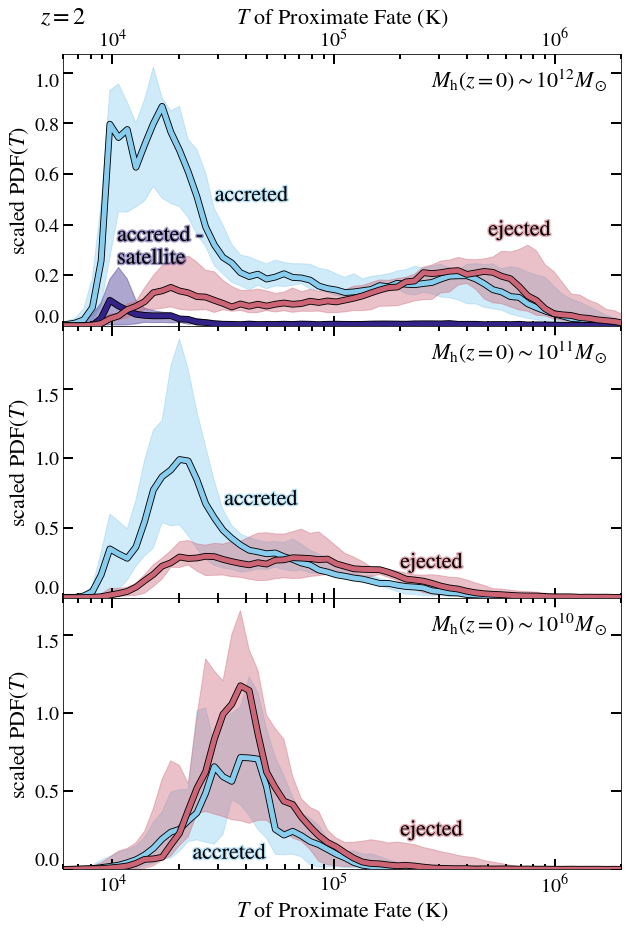

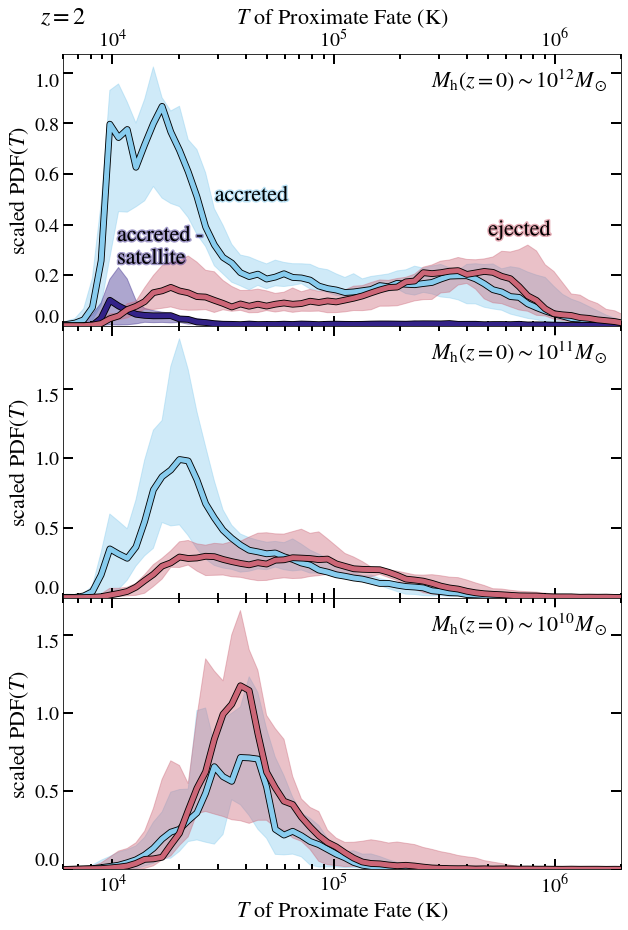

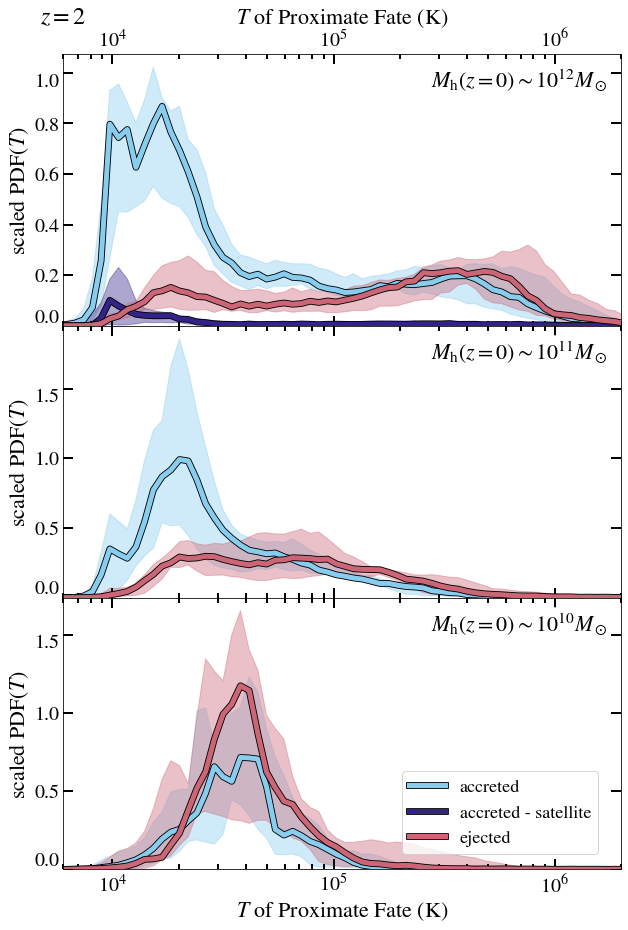

In [39]:
%matplotlib inline

for v in [ 'ann', 'part_ann', 'legend' ]:

    bins = np.linspace( 2., 7., 128 )

    n_rows = len( mass_bins )

    fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
    main_ax = plt.gca()

    gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
    gs.update(wspace=0.025, hspace=0.0001)

    norm_masses = data['M']['is_in_CGM'].sum()

    for i, mass_bin in enumerate( mass_bins ):

        ax = plt.subplot( gs[i,0] )

        maxes = []

        for j, classification in enumerate( plot_classification_list ):

            if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
                continue

            sub_data = data['T'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
            sub_masses = data['M'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]

            # Get the histograms out
            hists = verdict.Dict( {} )
            for sim_name in sub_data.keys():

                hists[sim_name], bins = np.histogram(
                    np.log10( sub_data[sim_name] ),
                    bins = bins,
    #                 weights = sub_masses[sim_name],
                    density = True,
                )

                hists[sim_name] *= sub_masses[sim_name].sum() / norm_masses[sim_name]

            # Plot actual lines
            x_arr = 10.**( bins[:-1] + 0.5*( bins[1] - bins[0] ) )
            h_arr = hists.array()  
            line = ax.plot(
                x_arr,
                np.nanmedian( h_arr, axis=0 ),
                color = p_constants.CLASSIFICATION_COLORS_B[classification],
                linewidth = 5,
                label = p_constants.CLASSIFICATION_LABELS[classification]
            )
            line[0].set_path_effects([
                path_effects.Stroke(
                    linewidth=6.75, 
                    foreground='k',
                ),
                path_effects.Normal(),
            ])
            upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
            ax.fill_between(
                x_arr,
                np.nanpercentile( h_arr, 16, axis=0 ),
                upper_percentile,
                color = p_constants.CLASSIFICATION_COLORS_B[classification],
                alpha = 0.4,
            )

            maxes.append( upper_percentile.max() )

    #     t_vir_bin = virial_temps.split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
    #     ax.axvline(
    #         t_vir_bin.median(),
    #         linewidth = 3,
    #         color = 'k',
    #         linestyle = '--',
    #     )
    #     ax.axvline(
    #         t_vir_bin.nanpercentile( 16. ),
    #         linewidth = 3,
    #         color = 'k',
    #         linestyle = '--',
    #     )
    #     ax.axvline(
    #         t_vir_bin.nanpercentile( 84. ),
    #         linewidth = 3,
    #         color = 'k',
    #         linestyle = '--',
    #     )

        ax.set_xscale( 'log' )
        ax.set_xlim( 6e3, 2e6 )
        ax.set_ylim( 0, np.nanmax( np.array( maxes ) )*1.05 )

        # Labels
        ax.set_xlabel( r'$T$ of Proximate Fate (K)', fontsize=22 )
        if ax.is_first_row():
            ax.xaxis.set_label_position( 'top' )
        ax.set_ylabel( r'scaled PDF$( T )$', fontsize=22, )

        # Bin labels
        bbox_props = dict( fc="w", alpha=0.75, lw=0 )
        xy = {
            465: ( 0.025, 0.95 ),
            172: ( 0.975, 0.95 ),
        }
        ha = {
            465: 'left',
            172: 'right',
        }
        ax.annotate(
            s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
            xy = xy[snum],
            xycoords = 'axes fraction',
            horizontalalignment = ha[snum],
            verticalalignment = 'top',
            fontsize = 22,
            bbox = bbox_props,
        )

        # Hide some axis labels
        if not ax.is_last_row():
            ax.tick_params( labelbottom = False )
        if ax.is_first_row():
            ax.tick_params( labeltop = True )

        # Avoid overlapping ticks
        ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
        ax.get_yticklabels()[-2].set_verticalalignment( 'top' )

        # Plot label
        if ax.is_first_row():
            ax.annotate(
                s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
                xy = ( 0.0, 1.0 ),
                xytext = ( 0., 25., ),
                xycoords = 'axes fraction',
                textcoords = 'offset points',
                horizontalalignment = 'center',
                verticalalignment = 'bottom',
                fontsize = 24,
            )

        # Adjust tick parameters
        ax.tick_params( direction='in', which='both', top=True, right=True )
        
        # Legend
        if v == 'legend':
            
            legend_args = {
                465: {
                    'loc': 'upper right',
                    'bbox_to_anchor': ( 0.975, 0.975),
                },
                172: {
                    'loc': 'lower right',
                    'bbox_to_anchor': ( 0.975, 0.025),
                },
            }
            
            if ax.is_first_row():
                handles, labels = ax.get_legend_handles_labels()

            if ( snum == 465 and ax.is_last_row() ) or ( snum == 172 and ax.is_last_row() ):
                
                legend = ax.legend(
                    handles,
                    labels,
                    prop = { 'size': 18 },
                    ncol = 1,
                    **legend_args[snum]
                )
                legend.set_zorder( 1000 )

    # Add labels
    part_ann_ax = {
        465: 1,
        172: 0,
    }
    line_label_args = {
        465: {
            0: {
                'is_CGM_accreted': {
                    'xy': ( 1.8e4, 0.0062*30 ),
                },
                'is_CGM_accreted_to_satellite': {
                    's': 'accreted -\nsatellite',
                    'xy': (1.3e4, 0.35 ),
                },
                'is_CGM_ejected': {
                    'xy': ( 1e5, 0.0 ),
                    'xytext': ( 5.5e4, 0.25 ),
                    'arrowprops': {
                        'arrowstyle': '-',
                        'linewidth': 2,
                        'color': linefinder_config.COLORSCHEME['is_CGM_ejected'],
                    }
                },
                'is_CGM_still': {
                    's': 'remains\nCGM',
                    'xy': ( 7e5, 0.025*30 ),
                },
            },
            1: {
                'is_CGM_accreted': {
                    'xy': ( 2e4, 0.33 ),
                },
                'is_CGM_accreted_to_satellite': {
                    's': 'accreted -\nsatellite',
                    'xy': (1.15e4, 0.44 ),
                },
                'is_CGM_ejected': {
                    'xy': ( 8e5, 0.06 ),
                },
                'is_CGM_still': {
                    's': 'remains\nCGM',
                    'xy': ( 1.35e5, 0.6 ),
                },
            },
            2: {
                'is_CGM_accreted': {
                    'xy': ( 9e3, 0.7 ),
                },
                'is_CGM_ejected': {
                    'xy': ( 2e5, 0.2 ),
                },
                'is_CGM_still': {
                    's': 'remains\nCGM',
                    'xy': ( 5e4, 1.5 ),
                },
            },
        },
        172: {
            0: {
                'is_CGM_accreted': {
                    'xy': ( 2.9e4, 0.019*27 ),
                },
                'is_CGM_ejected': {
                    'xy': ( 5e5, 0.014*27 ),
                },
                'is_CGM_accreted_to_satellite': {
                    's': 'accreted -\nsatellite',
                    'xy': (1.05e4, 0.31 ),
                },
            },
            1: {
                'is_CGM_accreted': {
                    'xy': ( 3.2e4, 0.7 ),
                },
                'is_CGM_ejected': {
                    'xy': ( 2e5, 0.25 ),
                },
            },
            2: {
                'is_CGM_accreted': {
                    'xy': ( 2.3e4, 0.1 ),
                },
                'is_CGM_ejected': {
                    'xy': ( 2e5, 0.25 ),
                },
            },
        },
    }
    for i, mass_bin in enumerate( mass_bins ):
        
        if v == 'legend':
            continue
        
        if v == 'part_ann':
            if i != part_ann_ax[snum]:
                continue

        ax = plt.subplot( gs[i,0] )
        for key, item in line_label_args[snum][i].items():

            defaults = {
                's' : p_constants.CLASSIFICATION_LABELS[key],
                'fontsize' : 22,
                'color' : 'k',
                'va': 'center',
                'ha': 'left',
            }
            args = utilities.merge_two_dicts( item, defaults )

            text = ax.annotate( **args )
            if snum == 465:
                text.set_zorder( -1000 )

            if key == 'is_CGM_accreted_to_satellite':
                alpha = 0.45
            else:
                alpha = 0.55
            text.set_path_effects([
                path_effects.Stroke(
                    linewidth=3, 
                    foreground=linefinder_config.COLORSCHEME[key],
                    alpha = alpha,
                ),
                path_effects.Normal(),
            ])

    save_file = 'temp_of_prox_fate_{}{}.pdf'.format( v, tag_tail )
    plotting.save_fig(
        out_dir = file_manager.project_parameters['extras_dir'],
        save_file = save_file,
        fig = fig,
    )
    
    # Publishable Version
    if v == 'part_ann':
        save_file = 'temp_of_prox_fate{}.pdf'.format( tag_tail )

        plotting.save_fig(
            out_dir = file_manager.get_project_figure_dir(),
            save_file = save_file,
            fig = fig,
        )

## Metallicity

### CDF

In [ ]:
bins = np.linspace( -4.2, 2, 256 )

n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

for i, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot( gs[i,0] )
    
    maxes = []

    for j, classification in enumerate( plot_classification_list ):
        
        if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
            continue

        sub_data = data['Z_asplund'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]

        # Get the histograms out
        hists = verdict.Dict( {} )
        for sim_name in sub_data.keys():

            hists[sim_name], bins = np.histogram(
                np.log10( sub_data[sim_name] ),
                bins = bins,
                density = True,
            )

            hists[sim_name] = np.cumsum( hists[sim_name] ) * np.diff( bins )[0]

        # Plot actual lines
        x_arr = 10.**( bins[:-1] + 0.5*( bins[1] - bins[0] ) )
        h_arr = hists.array()  
        line = ax.plot(
            x_arr,
            np.nanmedian( h_arr, axis=0 ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            linewidth = 5,
            label = p_constants.CLASSIFICATION_LABELS[classification],
        )
        line[0].set_path_effects([
            path_effects.Stroke(
                linewidth=7, 
                foreground='k',
            ),
            path_effects.Normal(),
        ])
#         line = ax.plot(
#             x_arr,
#             np.nanpercentile( h_arr, 16, axis=0 ),
#             color = p_constants.CLASSIFICATION_COLORS_B[classification],
#             linewidth = 1.5,
# #             linestyle = '--',
#         )
#         line = ax.plot(
#             x_arr,
#             np.nanpercentile( h_arr, 84, axis=0 ),
#             color = p_constants.CLASSIFICATION_COLORS_B[classification],
#             linewidth = 1.5,
# #             linestyle = '--',
#         )
        upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
#         alphas = {
#             'is_CGM_still': 0.5,
#             'is_CGM_accreted': 0.3,
#             'is_CGM_accreted_to_satellite': 0.1,
#             'is_CGM_ejected': 0.3,
#         }
        ax.fill_between(
            x_arr,
            np.nanpercentile( h_arr, 16, axis=0 ),
            upper_percentile,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
#             step = 'post',
        )
        
        maxes.append( upper_percentile.max() )

    ax.set_xscale( 'log' )
    ax.set_xlim( 1.45e-4, 3 )
    ax.set_ylim( 0, 1. )
    
    # Labels
    ax.set_xlabel( r'$Z$ of Proximate Fate $(Z_\odot)$', fontsize=22 )
    if ax.is_first_row():
        ax.xaxis.set_label_position( 'top' )
    ax.set_ylabel( r'CDF$(Z \mid$ prox. fate $)$', fontsize=22, )

    # Bin labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = ( 0.025, 0.95 ),
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22,
        bbox = bbox_props,
    )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
    
    # Legend
    if ax.is_first_row():
        handles, labels = ax.get_legend_handles_labels()
        
    if ( snum == 465 and ax.is_last_row() ) or ( snum == 172 and ax.is_first_row() ):
        legend = ax.legend(
            handles,
            labels,
            prop = { 'size': 18 },
            loc = 'lower right',
            bbox_to_anchor = ( 0.975, 0.025),
            ncol = 1,
        )
        legend.set_zorder( 1000 )

save_file = 'met_of_prox_fate{}.pdf'.format( tag_tail )

# plotting.save_fig(
#     out_dir = file_manager.get_project_figure_dir(),
#     save_file = save_file,
#     fig = fig,
# )

fig

### PDF

In [ ]:
# Find the mass at the metallicity floor or close to it
floor_cut = 10.**-3.5
m_at_floor = {}
for c, item in data['Z_asplund'].items():
    m_at_floor[c] = {}
    for sim, i_item in item.items():
        at_floor = i_item < floor_cut
        m_at_floor[c][sim] = data['M'][c][sim][at_floor].sum()
m_at_floor = verdict.Dict( m_at_floor )

In [ ]:
bins = np.linspace( np.log10( floor_cut ), 2, 64 )
# bins = np.insert( bins, 0, 10**-4.2 )

n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

norm_masses = data['M']['is_in_CGM'].sum()

for i, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot( gs[i,0] )
    
    maxes = []

    for j, classification in enumerate( plot_classification_list ):
        
        if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
            continue

        sub_data = data['Z_asplund'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        sub_masses = data['M'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        
        # Plot floor contribution
#         floor_frac = ( m_at_floor[classification] / data['M'][classification].sum() )
        floor_frac = ( m_at_floor[classification] / norm_masses )
        line = ax.hlines(
            floor_frac.nanmedian(),
            -4.5,
            floor_cut,
            linewidth = 5,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
        )
        line.set_path_effects([
            path_effects.Stroke(
                linewidth=7, 
                foreground='k',
            ),
            path_effects.Normal(),
        ])
#         ax.hlines(
#             floor_frac.nanpercentile( 16 ),
#             -4.5,
#             floor_cut,
#             linewidth = 2,
#             linestyle = '--',
#             color = p_constants.CLASSIFICATION_COLORS_B[classification],
#         )
#         ax.hlines(
#             floor_frac.nanpercentile( 84 ),
#             -4.5,
#             floor_cut,
#             linewidth = 2,
#             linestyle = '--',
#             color = p_constants.CLASSIFICATION_COLORS_B[classification],
#         )
        ax.fill_between(
            [-4.5, floor_cut],
            [ floor_frac.nanpercentile( 16. ), ]*2,
            [ floor_frac.nanpercentile( 84. ), ]*2,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
#             step = 'post',
        )

        # Get the histograms out
        hists = verdict.Dict( {} )
        for sim_name in sub_data.keys():

            hists[sim_name], bins = np.histogram(
                np.log10( sub_data[sim_name] ),
                bins = bins,
#                 weights = sub_masses[sim_name],
                density = True
            )
            hists[sim_name] *= (
                ( data['M'][classification].sum() - m_at_floor[classification] )
                / norm_masses
            )[sim_name]

#             hists[sim_name] /= norm_masses[sim_name]

        # Plot actual lines
        x_arr = 10.**( bins[:-1] + 0.5*( bins[1] - bins[0] ) ) 
        h_arr = hists.array()  
        line = ax.plot(
            x_arr,
            np.nanmedian( h_arr, axis=0 ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            linewidth = 5,
            label = p_constants.CLASSIFICATION_LABELS[classification],
        )
        line[0].set_path_effects([
            path_effects.Stroke(
                linewidth=7, 
                foreground='k',
            ),
            path_effects.Normal(),
        ])
        upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
        ax.fill_between(
            x_arr,
            np.nanpercentile( h_arr, 16, axis=0 ),
            upper_percentile,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
#             step = 'post',
        )
        
        maxes.append( upper_percentile.max() )
        
#     # Add a dividing line at the metallicity floor
#     ax.axvline(
#         floor_cut,
#         color = 'k',
#         linewidth = 1.5,
#     )

    ax.set_xscale( 'log' )
    ax.set_xlim( 1.45e-4, 3 )
    ax.set_ylim( 0, 0.45)
    
    # Labels
    ax.set_xlabel( r'$Z$ of Proximate Fate $(Z_\odot)$', fontsize=22 )
    if ax.is_first_row():
        ax.xaxis.set_label_position( 'top' )
    ax.set_ylabel( r'$f(M_{\rm CGM} \mid Z$, prox. fate $)$', fontsize=22, )

    # Bin labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = ( 0.025, 0.95 ),
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22,
        bbox = bbox_props,
    )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
    
    # Legend
    if ax.is_first_row():
        handles, labels = ax.get_legend_handles_labels()
        
    if ( snum == 465 and ax.is_last_row() ) or ( snum == 172 and i == 1):
        legend = ax.legend(
            handles,
            labels,
            prop = { 'size': 18 },
            loc = 'upper right',
            bbox_to_anchor = ( 0.975, 0.975),
            ncol = 1,
        )
        legend.set_zorder( 1000 )

save_file = 'met_of_prox_fate{}.pdf'.format( tag_tail )

# plotting.save_fig(
#     out_dir = file_manager.get_project_figure_dir(),
#     save_file = save_file,
#     fig = fig,
# )

fig

In [ ]:
bins = np.linspace( np.log10( floor_cut ), 2, 64 )
bins = np.insert( bins, 0, -4.2 )

n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

norm_masses = data['M']['is_in_CGM'].sum()

for i, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot( gs[i,0] )
    
    maxes = []

    for j, classification in enumerate( plot_classification_list ):
        
        if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
            continue

        sub_data = data['Z_asplund'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        sub_masses = data['M'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]

        # Get the histograms out
        hists = verdict.Dict( {} )
        for sim_name in sub_data.keys():

            hists[sim_name], bins = np.histogram(
                np.log10( sub_data[sim_name] ),
                bins = bins,
                density = True
            )
            hists[sim_name] *= sub_masses[sim_name].sum() / norm_masses[sim_name]

        # Plot actual lines
        x_arr = 10.**( bins[:-1] + 0.5*( bins[-1] - bins[-2] ) )
        x_arr[0:2] = 10.**( bins[0:2] )
        h_arr = hists.array()  
        
        # Modify just to make a step function
        x_arr = np.insert( x_arr, 1, floor_cut )
        def repeat_first( arr ):
            return np.insert( arr, 1, arr[0] )
        
        line = ax.plot(
            x_arr,
            repeat_first( np.nanmedian( h_arr, axis=0 ) ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            linewidth = 5,
            label = p_constants.CLASSIFICATION_LABELS[classification],
        )
        line[0].set_path_effects([
            path_effects.Stroke(
                linewidth=7, 
                foreground='k',
            ),
            path_effects.Normal(),
        ])
        upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
        ax.fill_between(
            x_arr,
            repeat_first( np.nanpercentile( h_arr, 16, axis=0 ) ),
            repeat_first( upper_percentile ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
#             step = 'post',
        )
        
        maxes.append( upper_percentile.max() )

    ax.set_xscale( 'log' )
    ax.set_xlim( 1.45e-4, 3 )
    ax.set_ylim( 0, np.nanmax( np.array( maxes ) )*1.05 )
    
    # Labels
    ax.set_xlabel( r'$Z$ of Proximate Fate $(Z_\odot)$', fontsize=22 )
    if ax.is_first_row():
        ax.xaxis.set_label_position( 'top' )
    ax.set_ylabel( r'$f(M_{\rm CGM}) \times$ PDF$( Z )$', fontsize=22, )

    # Bin labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = ( 0.1, 0.95 ),
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22,
        bbox = bbox_props,
    )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
        
# Add labels
line_label_args = {
    465: {
#         'is_CGM_accreted': {
#             'xy': ( 2e4, 0.0065 ),
#         },
#         'is_CGM_accreted_to_satellite': {
#             's': 'accreted -\nsatellite',
#             'xy': (1.25e4, 0.014 ),
#         },
#         'is_CGM_ejected': {
#             'xy': ( 3.15e5, 0.0125 ),
#         },
        'is_CGM_still': {
            's': 'remains\nCGM',
            'xy': ( 3e-3, .15 ),
        }
    },
    172: {
        'is_CGM_accreted': {
            'xy': ( 2e-3, 0.18 ),
        },
        'is_CGM_ejected': {
            'xy': ( 0.17, 0.1 ),
        }
    },
}
axes = {
    465: {
        'is_CGM_accreted': 0,
        'is_CGM_accreted_to_satellite': 0,
        'is_CGM_ejected': 1,
        'is_CGM_still': 0,
    },
    172: {
        'is_CGM_accreted': 1,
        'is_CGM_ejected': 2,
    }
}
for key, item in line_label_args[snum].items():
    
    ax = plt.subplot( gs[axes[snum][key],0] )
    
    defaults = {
        's' : p_constants.CLASSIFICATION_LABELS[key],
        'fontsize' : 22,
        'color' : 'k',
        'va': 'center',
        'ha': 'left',
    }
    args = utilities.merge_two_dicts( item, defaults )

    text = ax.annotate( **args )

    text.set_path_effects([
        path_effects.Stroke(
            linewidth=3, 
            foreground=linefinder_config.COLORSCHEME[key],
            alpha = 0.45,
        ),
        path_effects.Normal(),
    ])

save_file = 'met_of_prox_fate{}.pdf'.format( tag_tail )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

### Metallicity for only hot gas

In [ ]:
bins = np.linspace( np.log10( floor_cut ), 2, 64 )
bins = np.insert( bins, 0, -4.2 )

n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

norm_masses = data['M']['is_in_CGM'].sum()

for i, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot( gs[i,0] )
    
    maxes = []

    for j, classification in enumerate( plot_classification_list ):
        
        if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
            continue

        sub_data = data['Z_asplund'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        sub_masses = data['M'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        sub_temps = data['T'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        
        # Get the histograms out
        hists = verdict.Dict( {} )
        for sim_name in sub_data.keys():
            
            hist_data = sub_data[sim_name]
            hist_data = hist_data[sub_temps[sim_name] > 10.**4.7]

            hists[sim_name], bins = np.histogram(
                np.log10( hist_data ),
                bins = bins,
                density = True
            )
            hists[sim_name] *= sub_masses[sim_name].sum() / norm_masses[sim_name]

        # Plot actual lines
        x_arr = 10.**( bins[:-1] + 0.5*( bins[-1] - bins[-2] ) )
        x_arr[0:2] = 10.**( bins[0:2] )
        h_arr = hists.array()  
        
        # Modify just to make a step function
        x_arr = np.insert( x_arr, 1, floor_cut )
        def repeat_first( arr ):
            return np.insert( arr, 1, arr[0] )
        
        line = ax.plot(
            x_arr,
            repeat_first( np.nanmedian( h_arr, axis=0 ) ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            linewidth = 5,
            label = p_constants.CLASSIFICATION_LABELS[classification],
        )
        line[0].set_path_effects([
            path_effects.Stroke(
                linewidth=7, 
                foreground='k',
            ),
            path_effects.Normal(),
        ])
        upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
        ax.fill_between(
            x_arr,
            repeat_first( np.nanpercentile( h_arr, 16, axis=0 ) ),
            repeat_first( upper_percentile ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
#             step = 'post',
        )
        
        maxes.append( upper_percentile.max() )

    ax.set_xscale( 'log' )
    ax.set_xlim( 1.45e-4, 3 )
    ax.set_ylim( 0, np.nanmax( np.array( maxes ) )*1.05 )
    
    # Labels
    ax.set_xlabel( r'$Z$ of Proximate Fate $(Z_\odot)$', fontsize=22 )
    if ax.is_first_row():
        ax.xaxis.set_label_position( 'top' )
    ax.set_ylabel( r'$f(M_{\rm CGM}) \times$ PDF$( Z )$', fontsize=22, )

    # Bin labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = ( 0.1, 0.95 ),
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22,
        bbox = bbox_props,
    )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
        
# Add labels
line_label_args = {
    465: {
#         'is_CGM_accreted': {
#             'xy': ( 2e4, 0.0065 ),
#         },
#         'is_CGM_accreted_to_satellite': {
#             's': 'accreted -\nsatellite',
#             'xy': (1.25e4, 0.014 ),
#         },
#         'is_CGM_ejected': {
#             'xy': ( 3.15e5, 0.0125 ),
#         },
        'is_CGM_still': {
            's': 'remains\nCGM',
            'xy': ( 3e-3, .15 ),
        }
    },
    172: {
        'is_CGM_accreted': {
            'xy': ( 2e-3, 0.18 ),
        },
        'is_CGM_ejected': {
            'xy': ( 0.17, 0.1 ),
        }
    },
}
axes = {
    465: {
        'is_CGM_accreted': 0,
        'is_CGM_accreted_to_satellite': 0,
        'is_CGM_ejected': 1,
        'is_CGM_still': 0,
    },
    172: {
        'is_CGM_accreted': 1,
        'is_CGM_ejected': 2,
    }
}
for key, item in line_label_args[snum].items():
    
    ax = plt.subplot( gs[axes[snum][key],0] )
    
    defaults = {
        's' : p_constants.CLASSIFICATION_LABELS[key],
        'fontsize' : 22,
        'color' : 'k',
        'va': 'center',
        'ha': 'left',
    }
    args = utilities.merge_two_dicts( item, defaults )

    text = ax.annotate( **args )

    text.set_path_effects([
        path_effects.Stroke(
            linewidth=3, 
            foreground=linefinder_config.COLORSCHEME[key],
            alpha = 0.45,
        ),
        path_effects.Normal(),
    ])

save_file = 'met_of_prox_fate{}.pdf'.format( tag_tail )

# plotting.save_fig(
#     out_dir = file_manager.get_project_figure_dir(),
#     save_file = save_file,
#     fig = fig,
# )

fig

### Metallicity for metal diffusion vs non-metal diffusion

In [ ]:
bins = np.linspace( np.log10( floor_cut ), 2, 64 )
bins = np.insert( bins, 0, -4.2 )

n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

norm_masses = data['M']['is_in_CGM'].sum()

for i, mass_bin in enumerate( mass_bins ):

    ax = plt.subplot( gs[i,0] )

    maxes = []

    for j, classification in enumerate( plot_classification_list ):

        if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
            continue

        for md_flag in [ '', '_md' ]:
            md_data = data['Z_asplund'][classification].split_by_key_slice( slice(4,15) )[md_flag]
            md_masses = data['M'][classification].split_by_key_slice( slice(4,15) )[md_flag]
            sub_data = md_data.split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
            sub_masses = md_masses.split_by_dict( linefinder_config.MASS_BINS )[mass_bin]

            # Get the histograms out
            hists = verdict.Dict( {} )
            for sim_name in sub_data.keys():

                hists[sim_name], bins = np.histogram(
                    np.log10( sub_data[sim_name] ),
                    bins = bins,
                    density = True
                )
                hists[sim_name] *= sub_masses[sim_name].sum() / norm_masses[sim_name]

            # Plot actual lines
            x_arr = 10.**( bins[:-1] + 0.5*( bins[-1] - bins[-2] ) )
            x_arr[0:2] = 10.**( bins[0:2] )
            h_arr = hists.array()  

            # Modify just to make a step function
            x_arr = np.insert( x_arr, 1, floor_cut )
            def repeat_first( arr ):
                return np.insert( arr, 1, arr[0] )

            md_linestyles = {
                '': '-',
                '_md': '--',
            }
            line = ax.plot(
                x_arr,
                repeat_first( np.nanmedian( h_arr, axis=0 ) ),
                color = p_constants.CLASSIFICATION_COLORS_B[classification],
                linewidth = 5,
                label = p_constants.CLASSIFICATION_LABELS[classification],
                linestyle = md_linestyles[md_flag]
            )
            line[0].set_path_effects([
                path_effects.Stroke(
                    linewidth=7, 
                    foreground='k',
                ),
                path_effects.Normal(),
            ])
#             if md_flag == '_md':
#                 upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
#                 ax.fill_between(
#                     x_arr,
#                     repeat_first( np.nanpercentile( h_arr, 16, axis=0 ) ),
#                     repeat_first( upper_percentile ),
#                     color = p_constants.CLASSIFICATION_COLORS_B[classification],
#                     alpha = 0.4,
#         #             step = 'post',
#                 )

        maxes.append( upper_percentile.max() )

    ax.set_xscale( 'log' )
    ax.set_xlim( 1.45e-4, 3 )
    ax.set_ylim( 0, np.nanmax( np.array( maxes ) )*1.05 )

    # Labels
    ax.set_xlabel( r'$Z$ of Proximate Fate $(Z_\odot)$', fontsize=22 )
    if ax.is_first_row():
        ax.xaxis.set_label_position( 'top' )
    ax.set_ylabel( r'$f(M_{\rm CGM}) \times$ PDF$( Z )$', fontsize=22, )

    # Bin labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = ( 0.1, 0.95 ),
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22,
        bbox = bbox_props,
    )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )

    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )

# Add labels
line_label_args = {
    465: {
#         'is_CGM_accreted': {
#             'xy': ( 2e4, 0.0065 ),
#         },
#         'is_CGM_accreted_to_satellite': {
#             's': 'accreted -\nsatellite',
#             'xy': (1.25e4, 0.014 ),
#         },
#         'is_CGM_ejected': {
#             'xy': ( 3.15e5, 0.0125 ),
#         },
        'is_CGM_still': {
            's': 'remains\nCGM',
            'xy': ( 3e-3, .15 ),
        }
    },
    172: {
        'is_CGM_accreted': {
            'xy': ( 2e-3, 0.18 ),
        },
        'is_CGM_ejected': {
            'xy': ( 0.17, 0.1 ),
        }
    },
}
axes = {
    465: {
        'is_CGM_accreted': 0,
        'is_CGM_accreted_to_satellite': 0,
        'is_CGM_ejected': 1,
        'is_CGM_still': 0,
    },
    172: {
        'is_CGM_accreted': 1,
        'is_CGM_ejected': 2,
    }
}
for key, item in line_label_args[snum].items():

    ax = plt.subplot( gs[axes[snum][key],0] )

    defaults = {
        's' : p_constants.CLASSIFICATION_LABELS[key],
        'fontsize' : 22,
        'color' : 'k',
        'va': 'center',
        'ha': 'left',
    }
    args = utilities.merge_two_dicts( item, defaults )

    text = ax.annotate( **args )

    text.set_path_effects([
        path_effects.Stroke(
            linewidth=3, 
            foreground=linefinder_config.COLORSCHEME[key],
            alpha = 0.45,
        ),
        path_effects.Normal(),
    ])

save_file = 'md_comp_met_of_prox_fate{}.pdf'.format( tag_tail )

plotting.save_fig(
    out_dir = file_manager.project_parameters['extras_dir'],
    save_file = save_file,
    fig = fig,
)

# Quantitative Values for the Paper

In [ ]:
import os

import py2tex.py2tex as py2tex

In [ ]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [ ]:
tex_file = py2tex.TeXVariableFile( tex_filepath )

In [ ]:
# Used for variable names
tex_redshift = {
    465: 'low',
    172: 'high',
}

## Load the Origins Data

In [ ]:
origins_file_manager = file_management.FileManager( project='CGM_origin' )
mass_budget_data_filepath = os.path.join(
    origins_file_manager.project_parameters['output_data_dir'],
    'halo_mass_content_FIRE2_snum{}.hdf5'.format( snum ),
)

In [ ]:
mass_budgets, attributes = verdict.Dict.from_hdf5(
    mass_budget_data_filepath,
    unpack = True,
)

## Fraction of Cold Gas

### Cool Gas

In [ ]:
# Get fraction of cool mass
cool_mass = {}
for classification, temp in data['T'].items():
    
    cool_mass[classification] = {}
    
    for sim_name, temp_sim in temp.items():
        
        is_cool = temp_sim < 10**4.7
        cool_mass[classification][sim_name] = data['M'][classification][sim_name][is_cool].sum()
        
cool_mass = verdict.Dict( cool_mass )

In [ ]:
acc_frac = ( cool_mass['is_CGM_accreted'] + cool_mass['is_CGM_accreted_to_satellite'] ) / cool_mass['is_in_CGM']

m11_or_higher_mass = {}
for key, item in linefinder_config.MASS_BINS.items():
    m11_or_higher_mass[key] = item != 'm10'

frac_m11_or_higher = acc_frac.split_by_dict( m11_or_higher_mass )[True].median()

np.testing.assert_allclose( frac_m11_or_higher, 0.8, atol=0.05 )

frac_m11_or_higher

### Cold Gas

In [ ]:
# Get fraction of cool mass
cold_mass = {}
for classification, temp in data['T'].items():
    
    cold_mass[classification] = {}
    
    for sim_name, temp_sim in temp.items():
        
        is_cold = temp_sim < 10**4.2
        cold_mass[classification][sim_name] = data['M'][classification][sim_name][is_cold].sum()
        
cold_mass = verdict.Dict( cold_mass )

In [ ]:
acc_frac = cold_mass['is_CGM_accreted_to_satellite'] / cold_mass['is_in_CGM']

acc_frac.split_by_dict( linefinder_config.MASS_BINS )['m12'].median()

### Look at Mass Contributions for m12 Halos

In [ ]:
mass_cgm = mass_budgets['M']['gas']['m_cgm'].split_by_dict(
    linefinder_config.MASS_BINS
)['m12'].nanmedian()
'{:.2g}'.format( mass_cgm )

In [ ]:
med_fraction_cool = ( cool_mass['is_in_CGM'] / data['M']['is_in_CGM'].sum() ).split_by_dict(
    linefinder_config.MASS_BINS
)['m12'].nanmedian()
med_fraction_cool

In [ ]:
med_mass_cool = mass_cgm * med_fraction_cool
'{:.2g}'.format( med_mass_cool )

In [ ]:
med_fraction_cool_acc = ( cool_mass['is_CGM_accreted'] / cool_mass['is_in_CGM'] ).split_by_dict(
    linefinder_config.MASS_BINS
)['m12'].nanmedian()
med_fraction_cool_acc

In [ ]:
med_mass_acc_cool = med_mass_cool * med_fraction_cool_acc
'{:.2g}'.format( med_mass_acc_cool )

In [ ]:
# Time til end of sim
t = w_set['m12i'].data_object.get_data( 'time' )
t_to_end = t[0] - t[ind]
t_to_end

In [ ]:
rough_acc_cool_rate = med_mass_acc_cool / ( t_to_end * 1e9 )
rough_acc_cool_rate

## Fraction of Hot Gas

In [ ]:
# Get fraction of cool mass
hot_mass = {}
for classification, temp in data['T'].items():
    
    hot_mass[classification] = {}
    
    for sim_name, temp_sim in temp.items():
        
        is_hot = ( temp_sim > 10**5 )
        hot_mass[classification][sim_name] = data['M'][classification][sim_name][is_hot].sum()
        
hot_mass = verdict.Dict( hot_mass )

### Look at Mass Contributions for m12 Halos

In [ ]:
mass_cgm = mass_budgets['M']['gas']['m_cgm'].split_by_dict(
    linefinder_config.MASS_BINS
)['m12'].nanmedian()
'{:.2g}'.format( mass_cgm )

In [ ]:
med_fraction_hot = ( hot_mass['is_in_CGM'] / data['M']['is_in_CGM'].sum() ).split_by_dict(
    linefinder_config.MASS_BINS
)['m12'].nanmedian()
med_fraction_hot

In [ ]:
med_mass_hot = mass_cgm * med_fraction_hot
'{:.2g}'.format( med_mass_hot )

In [ ]:
med_fraction_hot_acc = ( hot_mass['is_CGM_accreted'] / hot_mass['is_in_CGM'] ).split_by_dict(
    linefinder_config.MASS_BINS
)['m12'].nanmedian()
med_fraction_hot_acc

In [ ]:
med_mass_acc_hot = med_mass_hot * med_fraction_hot_acc
'{:.2g}'.format( med_mass_acc_hot )

In [ ]:
# Time til end of sim
t = w_set['m12i'].data_object.get_data( 'time' )
t_to_end = t[0] - t[ind]
t_to_end

In [ ]:
rough_acc_hot_rate = med_mass_acc_hot / ( t_to_end * 1e9 )
rough_acc_hot_rate

## Median Metallicity of Different Modes

In [ ]:
met_meds = {}
for classification, met in data['Z_asplund'].items():
    
    met_meds[classification] = met.apply( np.nanmedian )
met_meds = verdict.Dict( met_meds )

In [ ]:
if snum == 465:
    low_p = ( met_meds['is_CGM_accreted'] / met_meds['is_CGM_still'] ).nanpercentile( 16 )
    med_p = ( met_meds['is_CGM_accreted'] / met_meds['is_CGM_still'] ).nanmedian()
    high_p = ( met_meds['is_CGM_accreted'] / met_meds['is_CGM_still'] ).nanpercentile( 84 )

    low_p, med_p, high_p

In [ ]:
if snum == 172:
    low_p = ( met_meds['is_CGM_accreted'] / met_meds['is_CGM_ejected'] ).nanpercentile( 16 )
    med_p = ( met_meds['is_CGM_accreted'] / met_meds['is_CGM_ejected'] ).nanmedian()
    high_p = ( met_meds['is_CGM_accreted'] / met_meds['is_CGM_ejected'] ).nanpercentile( 84 )

    low_p, med_p, high_p

In [ ]:
low_p, med_p, high_p

In [ ]:
# Get fraction of cool mass
vhot_mass = {}
for classification, temp in data['T'].items():
    
    vhot_mass[classification] = {}
    
    for sim_name, temp_sim in temp.items():
        
        is_hot = ( temp_sim > 10**6 )
        vhot_mass[classification][sim_name] = data['M'][classification][sim_name][is_hot].sum()
        
vhot_mass = verdict.Dict( vhot_mass )